# ロジスティック回帰

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# 犯罪件数と失業者数のデータを読み込み
data = pd.read_csv('../data/crime_data.csv')
data

,id,area,population,unemployee,crime
0,1101,北海道 札幌市 中央区,202801,6542,6118
1,1102,北海道 札幌市 北区,272877,9277,4615
2,1103,北海道 札幌市 東区,253996,9448,4114
3,1104,北海道 札幌市 白石区,201307,8606,4132
4,1105,北海道 札幌市 豊平区,209428,7464,3231
...,...,...,...,...,...
1833,47361,沖縄県 久米島町,9177,530,58
1834,47362,沖縄県 八重瀬町,25121,1145,245
1835,47375,沖縄県 多良間村,1370,32,11
1836,47381,沖縄県 竹富町,4192,72,55


## 可視化と前振り

Text(0.5, 1.0, 'Crime vs Unemployee')

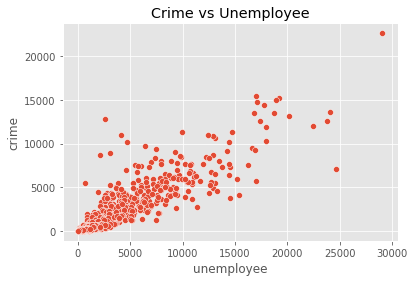

In [3]:
sns.scatterplot(x='unemployee', y='crime', data=data)
plt.title('Crime vs Unemployee')
#plt.savefig('CrimeVsUnemployee.png')

Text(0.5, 1.0, 'CrimeFlag vs Unemployee')

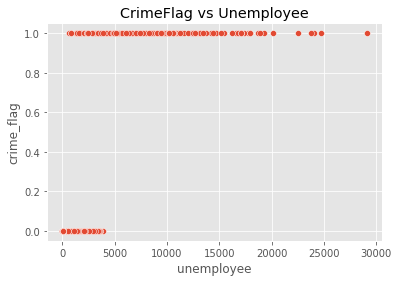

In [13]:
# 犯罪件数が平均以上の市町村にフラグを立てて新しい変数を作る
threshold = data['crime'].mean()
data['crime_flag'] = data['crime'].map(lambda x: 1 if x >= threshold else 0) 

sns.scatterplot(x='unemployee', y='crime_flag', data=data)
plt.title('CrimeFlag vs Unemployee')
#plt.savefig('CrimeFlagVsUnemployee.png')

Text(0.5, 1.0, 'Crime Histogram')

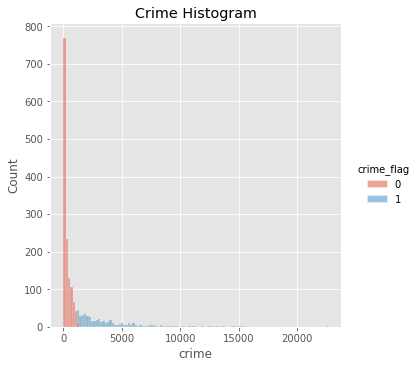

In [14]:
# ヒストグラムを確認する
sns.displot(x='crime', data=data, hue='crime_flag')
plt.title('Crime Histogram')
#plt.savefig('CrimeHistogram.png', bbox_inches="tight")

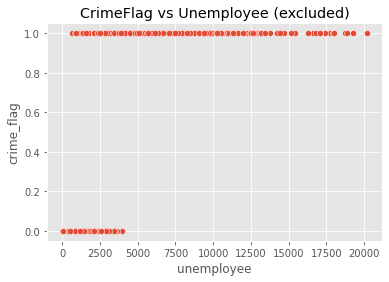

In [85]:
# 失業者数の上位5市町村を一旦取り除く
data2 = data.copy()
for i in range(5):
    data2 = data2.loc[data2['unemployee']!=data2['unemployee'].max(), :].reset_index(drop=True)

sns.scatterplot(x='unemployee', y='crime_flag', data=data2)
plt.title('CrimeFlag vs Unemployee (excluded)')
plt.savefig('CrimeFlagVsUnemployeeExcluded.png')

In [229]:
# 最小二乗法の関数を定義
def my_ols(X, y):
    # データ型を整える
    Xtmp = X.reshape(-1,1)
    ytmp = y.reshape(-1,1)
    fmat = np.append(np.ones(Xtmp.shape), Xtmp, axis=1)
    
    # 正規方程式を解く
    beta = np.linalg.pinv(fmat.T.dot(fmat)).dot(fmat.T).dot(ytmp)
    
    return beta

In [302]:
# 回帰結果を可視化する関数を定義
def reg_plot(X, y, beta):
    beta0 = beta[0]
    beta1 = beta[1]
    xmin = min(X)
    xmax = 30000
    threshpoint = (0.5-beta0)/beta1
    
    fig = plt.figure(figsize=(8,6))
    plt.scatter(X, y, color='red', s=20, alpha=0.8, linewidth=1, ec='mistyrose')
    plt.plot([xmin,xmax], [beta0+beta1*xmin, beta0+beta1*xmax], color='k')
    plt.scatter(threshpoint, 0.5, color='dodgerblue', marker='o')
    plt.plot([0,threshpoint], [0.5,0.5], color='dodgerblue', linewidth=1, linestyle='dashed')
    plt.plot([threshpoint,threshpoint], [0,beta0+beta1*xmax], color='dodgerblue', linewidth=1, linestyle='dashed')
    
    plt.title('Classified by Liner Regression Model (excluded)')
    plt.xlabel('unemployee')
    plt.ylabel('crime_flag')
    plt.show()
    fig.savefig('ClassifiedByLinerRegressionModelExcluded.png')

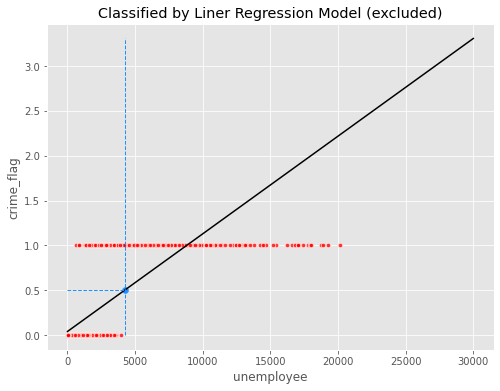

beta0:0.039153602235165466
beta1:0.00010895741021290774


In [303]:
# 失業者数上位5市町村を一旦取り除いた状態で線形回帰モデルを当てはめる
X = data2['unemployee'].values
y = data2['crime_flag'].values

# 最小二乗法で線形回帰を実行
params = my_ols(X, y)

# 最小二乗法の回帰結果を可視化
reg_plot(X, y, params)
# 最小二乗法の結果求まったパラメータを表示
print('beta0:{}'.format(params[0][0]))
print('beta1:{}'.format(params[1][0]))

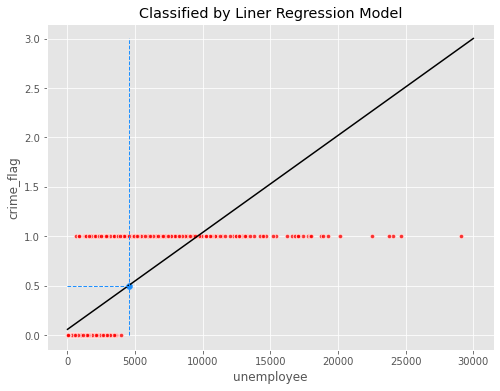

beta0:0.05684067809712338
beta1:9.82039052002563e-05


In [301]:
# 失業者数上位5市町村を含めて線形回帰モデルを当てはめる
X = data['unemployee'].values
y = data['crime_flag'].values

# 最小二乗法で線形回帰を実行
params = my_ols(X, y)

# 最小二乗法の回帰結果を可視化
reg_plot(X, y, params)
# 最小二乗法の結果求まったパラメータを表示
print('beta0:{}'.format(params[0][0]))
print('beta1:{}'.format(params[1][0]))

In [254]:
# Accuracyの計算
from sklearn.metrics import accuracy_score

# 0.5を閾値として0/1に変換
p = params[0][0] + params[1][0]*X
to_prob = (lambda x: 1 if x >= 0.5 else 0)
y_pred = np.array([to_prob(i) for i in p])

score = accuracy_score(y_true=y, y_pred=y_pred)
print('Accuracy：{}'.format(score))

Accuracy：0.8699673558215452


## 勾配降下法

In [92]:
# シグモイド関数を定義
def my_sigmoid(x):
    return 1/(1+np.exp(-x))

In [256]:
# 全市町村のデータを読み込み
X = data['unemployee'].values
y = data['crime_flag'].values

# 勾配降下法を実行
# 実行設定
# ============ここから下の数字を弄って結果がどう変わるかを試してみてください=========
alpha = 0.1 # 学習率
iterations = 1000 # 繰り返し回数
beta0 = 1 # パラメータbeta0の初期値
beta1 = 1 # パラメータbeta1の初期値
# ============弄るのはここまで============================================

# 標準化（何をやっているかは後々説明します）
X = (X-X.mean())/X.std()

# beta0とbeta1をまとめてパラメータの列ベクトルbetaを作る
beta = np.append(np.array([[beta0]]), np.array([[beta1]]), axis=1).reshape(-1,1)

# データ型を整える
Xtmp = X.reshape(-1,1)
ytmp = y.reshape(-1,1)
fmat = np.append(np.ones(Xtmp.shape), Xtmp, axis=1)

# 探索過程を保存するハコを用意
J_history = np.zeros(iterations)
beta_history = np.zeros((iterations,2))

# サンプルサイズ取得
n = len(X)

# 勾配降下法を実行
# 線形回帰との違いは損失関数の式および勾配の式の２箇所です
for i in range(iterations):
    # 勾配を計算
    p = my_sigmoid(fmat.dot(beta))
    grad = ((fmat).T.dot(p-ytmp))/n
    # パラメータを更新
    beta = beta - alpha*grad
    # 損失を計算
    logloss = ytmp.T.dot(np.log(p)) + (1-ytmp).T.dot(np.log(1-p))
    J = logloss/(-n)
    
    # 探索過程の損失とパラメータをハコに格納
    J_history[i] = J[0][0]
    beta_history[i,:] = beta.T

/var/folders/v6/1f2j3j154zj9g03clj2_yt_00000gn/T/ipykernel_54515/4162210921.py:41: RuntimeWarning: divide by zero encountered in log
  logloss = ytmp.T.dot(np.log(p)) + (1-ytmp).T.dot(np.log(1-p))


Text(0, 0.5, 'cost function')

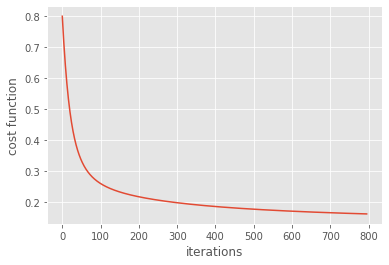

In [257]:
# 損失関数の変化を可視化
plt.plot(J_history)
plt.xlabel('iterations')
plt.ylabel('cost function')

/var/folders/v6/1f2j3j154zj9g03clj2_yt_00000gn/T/ipykernel_54515/995582213.py:15: RuntimeWarning: divide by zero encountered in log
  logloss = ytmp.T.dot(np.log(p)) + (1-ytmp).T.dot(np.log(1-p))


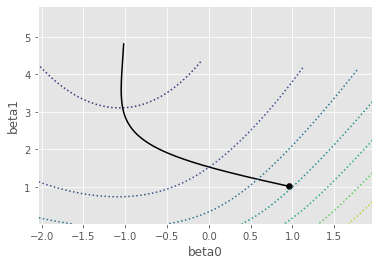

In [258]:
# 勾配降下法の探索過程を可視化
# 黒ポチは上で設定した初期値から最初に更新したbeta、黒ポチから伸びる線の先が最終的に求まったbetaです
plt.scatter(beta_history[0,0], beta_history[0,1], color='k', marker='o')
plt.plot(beta_history[:,0], beta_history[:,1], color='k', linewidth=1.5)
xs = np.linspace(min(beta_history[:,0])-1, max(beta_history[:,0])+1, 100)
ys = np.linspace(min(beta_history[:,1])-1, max(beta_history[:,1])+1, 100)
xmesh, ymesh = np.meshgrid(xs, ys)
xx = np.append(xmesh.reshape(-1,1), ymesh.reshape(-1,1), axis=1)

n = len(X)
zs = np.zeros(xx.shape[0])
for i in range(len(zs)):
    betatmp = xx[i,:].reshape(-1,1)
    p = my_sigmoid(fmat.dot(betatmp))
    logloss = ytmp.T.dot(np.log(p)) + (1-ytmp).T.dot(np.log(1-p))
    buf = logloss/(-n)
    zs[i] = buf

plt.contour(xs, ys, zs.reshape(xmesh.shape), linestyles='dotted')
plt.xlabel('beta0')
plt.ylabel('beta1')
plt.show()

In [259]:
# ロジスティック回帰の結果を可視化する関数を定義
def logi_plot(X, y, beta):
    beta0 = beta[0]
    beta1 = beta[1]
    xmin = min(X)
    xmax = max(X)
    threshpoint = -beta0/beta1
    
    beta = np.append(np.array([[beta0]]), np.array([[beta1]]), axis=1).reshape(-1,1)
    Xtmp = X.reshape(-1,1)
    fmat = np.append(np.ones(Xtmp.shape), Xtmp, axis=1)
    p = my_sigmoid(fmat.dot(beta))
    
    fig = plt.figure(figsize=(8,6))
    plt.scatter(X, y, color='red', s=20, alpha=0.8, linewidth=1, ec='mistyrose')
    plt.scatter(X, p, color='k', s=5, alpha=0.5)
    plt.scatter(threshpoint, 0.5, color='dodgerblue', marker='o')
    plt.plot([0,threshpoint], [0.5,0.5], color='dodgerblue', linewidth=1, linestyle='dashed')
    plt.plot([threshpoint,threshpoint], [0,1], color='dodgerblue', linewidth=1, linestyle='dashed')
    
    plt.title('Classified by Logistic Regression Model')
    plt.xlabel('unemployee')
    plt.ylabel('crime flag')
    plt.show()
    fig.savefig('ClassifiedByLogisticRegressionModel.png')

/Users/suzuki001/Desktop/studyML/handson/src/venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


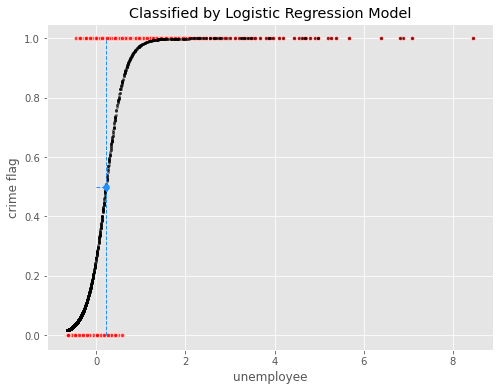

beta0:-1.0179852063907633
beta1:4.8119846787727445


In [264]:
# ロジスティック回帰の結果を可視化
logi_plot(X, y, beta)
# ロジスティック回帰で求まったパラメータを表示
print('beta0:{}'.format(beta[0][0]))
print('beta1:{}'.format(beta[1][0]))

In [265]:
# Accuracyの計算
from sklearn.metrics import accuracy_score

# 0.5を閾値として0/1に変換
p = my_sigmoid(beta[0][0] + beta[1][0]*X)
to_prob = (lambda x: 1 if x >= 0.5 else 0)
y_pred = np.array([to_prob(i) for i in p])

score = accuracy_score(y_true=y, y_pred=y_pred)
print('Accuracy：{}'.format(score))

Accuracy：0.9341675734494015


## scikit-learnの実装と比べてみる

In [224]:
from sklearn.linear_model import LogisticRegression

/Users/suzuki001/Desktop/studyML/handson/src/venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


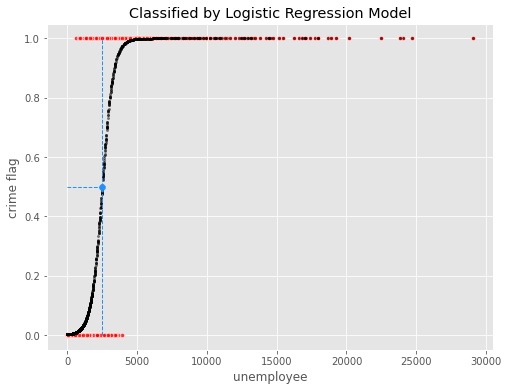

beta0:-6.26684214962875
beta1:0.0025154902431543556


In [291]:
# 全市町村のデータを読み込み
X = data['unemployee'].values
y = data['crime_flag'].values

clf = LogisticRegression(random_state=0, max_iter=1000, penalty='none')
clf.fit(X.reshape(-1,1), y.ravel())

# scikit-learnのロジスティック回帰の結果を可視化
clf_beta = np.array([clf.intercept_[0], clf.coef_[0][0]]).reshape(-1,1)
logi_plot(X, y, clf_beta)
# scikit-learnで求まったパラメータを表示
print('beta0:{}'.format(clf_beta[0][0]))
print('beta1:{}'.format(clf_beta[1][0]))

In [292]:
# Accuracyの出力
score = clf.score(X.reshape(-1,1),y.ravel())
print('Accuracy：{}'.format(score))

Accuracy：0.9428726877040261


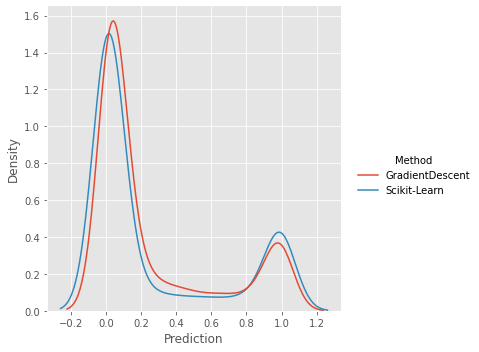

In [298]:
## 勾配降下法とscikit-learnの予測結果を比較
tmp1 = pd.DataFrame({})
tmp1['Prediction'] = p
tmp1['Method'] = 'GradientDescent'
tmp2 = pd.DataFrame({})
tmp2['Prediction'] = clf.predict_proba(X.reshape(-1,1))[:,1]
tmp2['Method'] = 'Scikit-Learn'
df_plot = pd.concat([tmp1, tmp2], axis=0).reset_index(drop=True)

sns.displot(x='Prediction', data=df_plot, hue='Method', kind='kde')

自分で勾配降下法により計算した結果とほとんど同じ形の予測結果が出た。  
ただし、勾配降下法の結果のグラフの横軸は標準化されていて、scikit-learnの結果のグラフは生値なのでスケールが異なっていることに注意する。  
パラメータの値やAccuracyの違いは以下によるもの  
- 最適化手法の違い  
    scikit-learnの実装には勾配降下法ではなくLBFGSという手法が用いられている  
    (http://kotarotanahashi.github.io/blog/2015/10/03/l-bfgsfalseshi-zu-mi/)